In [1]:
import requests
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

from operator import itemgetter

In [2]:
%matplotlib inline

In [3]:
mpl.rcParams['figure.figsize'] = (12.0, 8.0)

In [4]:
def get_table(query, header=None, url="https://query.wikidata.org/bigdata/namespace/wdq/sparql"):
    response = requests.get(url, params={'query': query, 'format': 'json'})
    if not response.ok:
        raise IOError("{0:d} - {1}".format(response.status_code, response.reason))
    content = response.json()
    columns = content["head"]["vars"]
    get_row = itemgetter(*columns)
    if header is not None:
        header_size = len(header)
        col_size = len(columns)
        if header_size != col_size:
            raise ValueError("header has the wrong shape - found {0:d} but expected {1:d}".format(header_size, col_size))
        columns = header
    get_val = itemgetter("value")
    data = [[get_val(elem) for elem in get_row(row)] for row in content["results"]["bindings"]]
    return pd.DataFrame(data, columns=columns)

In [5]:
def reshape(df, native_col="lang_code", trans_col="trans_code"):
    tmp = df.set_index([native_col, trans_col])  # create copy with MultiIndex
    # data may contain duplicate values, we remove them with first then unstack
    return tmp.groupby(level=[native_col, trans_col]).first().unstack()

In [6]:
lang_query = """
SELECT ?languageCode ?languageName ?nameLanguage WHERE {
  ?language wdt:P424 ?languageCode;
            rdfs:label ?languageName.
  BIND(LANG(?languageName) AS ?nameLanguage).
}
ORDER BY ?languageCode ?nameLanguage
"""

In [7]:
langs = get_table(lang_query, header=["lang_code", "lang_name", "trans_code"])

In [8]:
langs.describe()

,lang_code,lang_name,trans_code
count,37299,37299,37299
unique,388,31535,325
top,en,Esperanto,en
freq,454,79,1076


In [9]:
lang_matrix = reshape(langs)

In [10]:
lang_matrix.shape

(388, 325)

In [11]:
lang_matrix.head()

lang_name                                                           \
trans_code        aa            ab                abe         ace         ady   
lang_code                                                                       
aa          Qafár af          None               None        None        None   
ab              None  Аҧсуа бызшәа               None        None  Абхъазыбзэ   
abe             None          None  wôbanakiôdwawôgan        None        None   
ace             None          None               None  Bahsa Acèh        None   
acf             None          None               None        None        None   

                                                     ...                 \
trans_code   aeb aeb-arab aeb-latn         af    ak  ...      zh  zh-cn   
lang_code                                            ...                  
aa          None     None     None       None  None  ...    阿法爾語   None   
ab          None     None     None  Abchasies  None  ...   阿布哈茲語  阿布哈兹语   
abe         None     None     None       None  None  ...    None   None   
ace         None     None     None       None  None  ...     亚齐语   None   
acf         None     None     None       None  None  ...    None   None   

                                                                    
trans_code zh-hans zh-hant  zh-hk  zh-mo zh-my  zh-sg  zh-tw    zu  
lang_code                                                           
aa            None    None   None   None  None   None   None  None  
ab           阿布哈兹语   阿布哈茲語  阿布哈茲語  阿布哈茲語  None  阿布哈兹语  阿布哈茲語  None  
abe           None    None   None   None  None   None   None  None  
ace           None    None   None   None  None   None   None  None  
acf           None    None   None   None  None   None   None  None  

[5 rows x 325 columns]

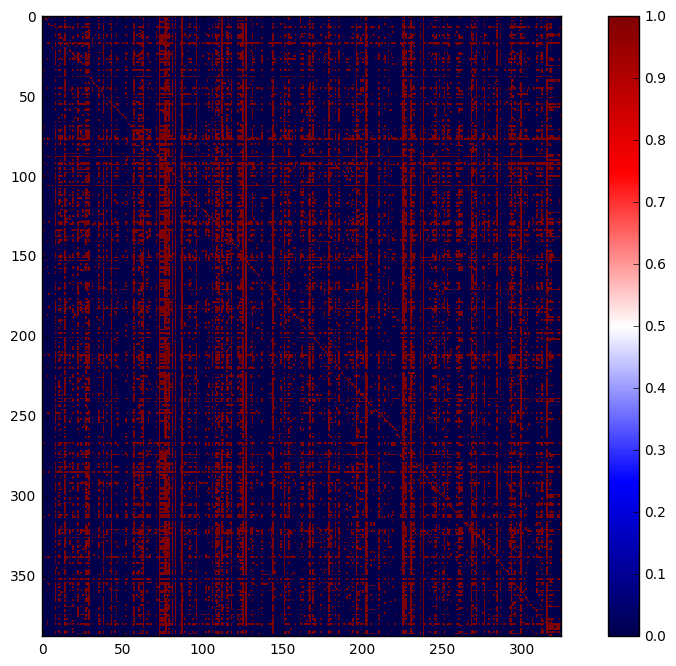

In [12]:
plt.imshow(lang_matrix.notnull(), interpolation="nearest", cmap=plt.cm.seismic)
plt.colorbar()
plt.show()

In [13]:
lang_freq = lang_matrix.notnull().sum(axis=1)

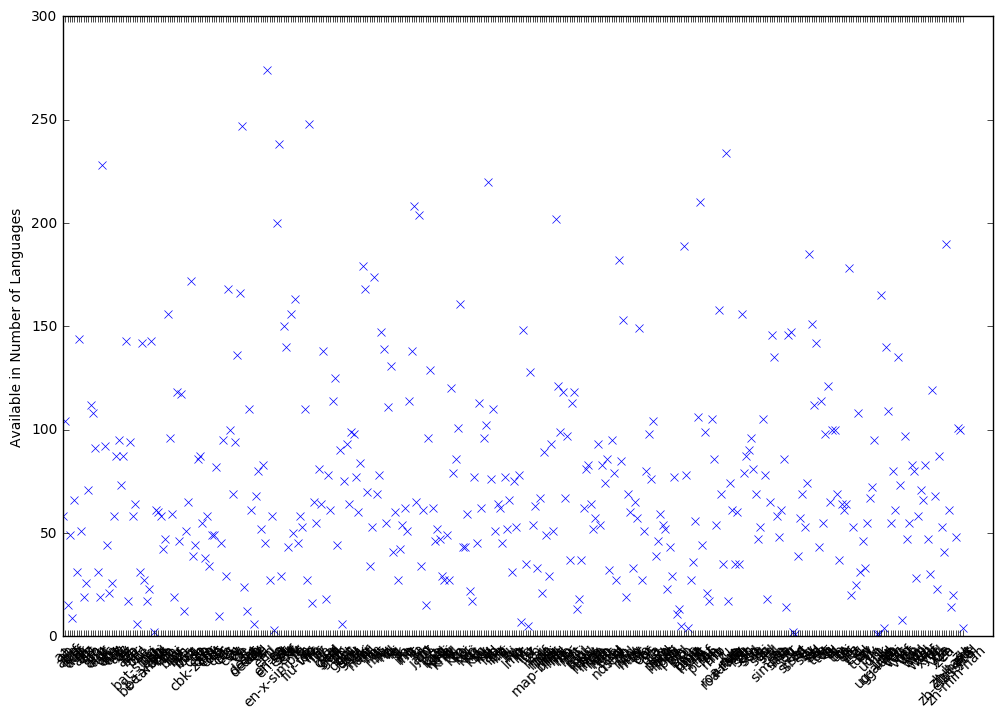

In [14]:
x = np.arange(len(lang_freq))
plt.plot(x, lang_freq, "x")
plt.xticks(x, lang_freq.index, rotation=45)
plt.ylabel("Available in Number of Languages")
plt.show()

In [15]:
lang_freq.sort_values(ascending=False)[:10]

lang_code
en    274
fr    248
de    247
es    238
ru    234
ar    228
la    220
pt    210
it    208
ja    204
dtype: int64

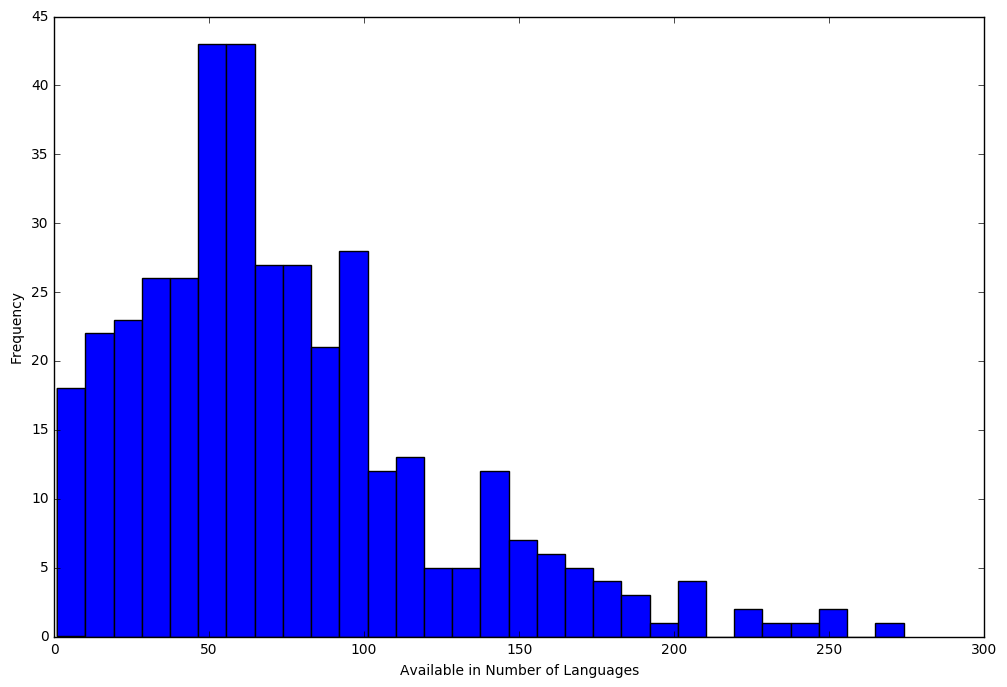

In [16]:
plt.hist(lang_freq, bins=30)
plt.xlabel("Available in Number of Languages")
plt.ylabel("Frequency")
plt.show()